In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import neural_network

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

kingdoms = ['arc', 'plm', 'rod', 'phg', 'pri', 'vrt', 'bct', 'pln', 'inv', 'mam', 'vrl']
kingdom_names = ['archaea', 'plasmid', 'rodent', 'bacteriophage', 'primate', 'vertebrate', 'bacteria', 'plant', 'invertebrate', 'mammal', 'virus']

In [31]:
def preprocess(file_path: str, test_size: float = 0.2, random_state: int = 42, split: bool = True) -> tuple:
    # Load the data
    codon_usage_df = pd.read_csv(file_path, low_memory=False)

    # Extracting the codon frequency columns and converting to numeric, coercing errors to NaN
    codon_columns = codon_usage_df.columns[5:]
    X = codon_usage_df[codon_columns].apply(pd.to_numeric, errors='coerce')
    y = codon_usage_df['Kingdom']

    # Drop rows with any NaN values in X and filter y accordingly
    X_clean = X.dropna()
    y_clean = y.loc[X_clean.index]

    scaler = StandardScaler()

    if split:
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=test_size, random_state=random_state)
    else:
        X_train, y_train = X_clean, y_clean

    # Standardize the data
    X_train_scaled = scaler.fit_transform(X_train)

    if split:
        X_test_scaled = scaler.transform(X_test)
    
    if split:
        return(X_train_scaled, X_test_scaled, y_train, y_test)
    else:
        return(X_train_scaled, y_train)

X_train, X_test, y_train, y_test = preprocess('codon_usage.csv', test_size=0.2, random_state=42)

def classify(classifier):
    # A valid classifier object presents the fit(numpy.ndarray, pandas.Series) -> None and predict(pandas.Series) -> numpy.ndarray functions
    print('\nTraining...\n')

    # Training the chosen classifier
    classifier.fit(X_train, y_train)

    # Making predictions
    y_pred = classifier.predict(X_test)

    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print('Classification Report:\n', classification_report(y_test, y_pred, zero_division=0))

def kingdom_to_color(kingdom: str):
    color = {
        'arc': (0, 0, 0),
        'plm': (125, 125, 125),
        'rod': (255, 0, 0),
        'phg': (0, 255, 0),
        'pri': (0, 0, 255),
        'vrt': (0, 125, 125),
        'bct': (125, 0, 125),
        'pln': (125, 125, 0),
        'inv': (0, 255, 255),
        'mam': (255, 0, 255),
        'vrl': (255, 255, 0),
    }[kingdom]
    return(color[0] / 255, color[1] / 255, color[2] / 255)

def visualize(visualizer, title: str):
    X, y = preprocess('codon_usage.csv', random_state=42, split=False)
    X_transformed =  visualizer.fit_transform(X)
    plt.title(title)
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=pd.Series(y).apply(kingdom_to_color), s=5)
    plt.xlabel("Reduced Dimension 1")
    plt.ylabel("Reduced Dimension 2")

    handles = [mpatches.Patch(color=kingdom_to_color(kingdom), label=kingdom) for kingdom in kingdoms]
    plt.legend(handles, kingdom_names, ncol=1, bbox_to_anchor=(1, 1))

    plt.show()


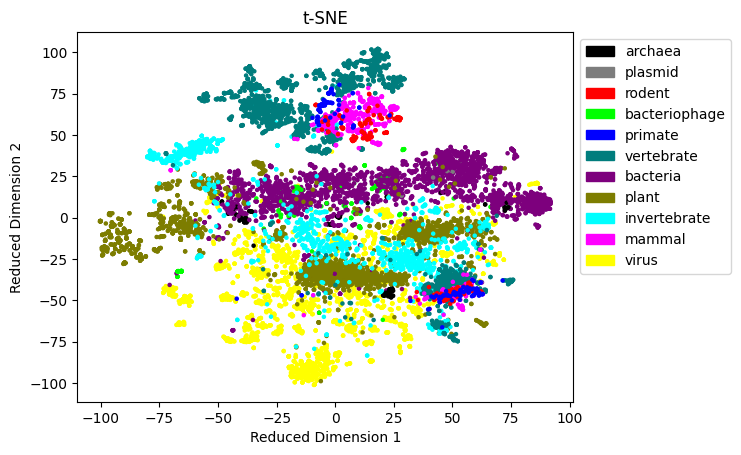

In [32]:
visualize(TSNE(n_components=2), 't-SNE')

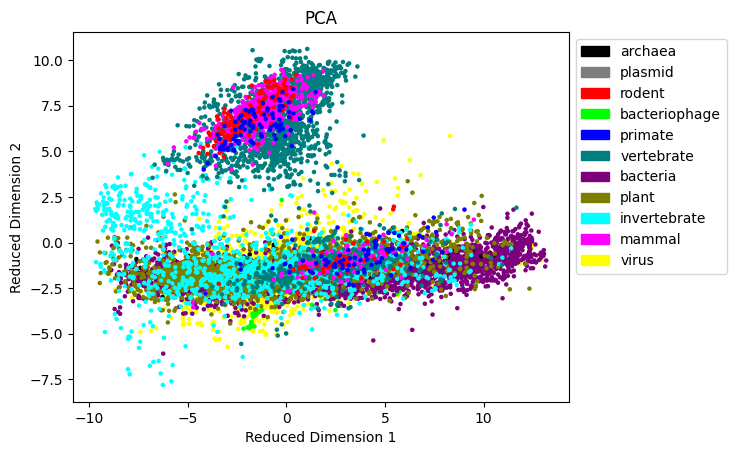

In [34]:
visualize(PCA(n_components=2), 'PCA')

In [27]:
classify(
    RandomForestClassifier(n_estimators=100, random_state=42)
)


Training...

Accuracy: 89.03%
Classification Report:
               precision    recall  f1-score   support

         arc       0.91      0.43      0.59        23
         bct       0.90      0.96      0.93       604
         inv       0.89      0.70      0.79       291
         mam       0.88      0.80      0.84       112
         phg       0.92      0.50      0.65        46
         plm       0.00      0.00      0.00         5
         pln       0.87      0.92      0.89       495
         pri       0.91      0.50      0.65        40
         rod       0.90      0.70      0.79        40
         vrl       0.88      0.95      0.92       575
         vrt       0.91      0.96      0.93       375

    accuracy                           0.89      2606
   macro avg       0.82      0.68      0.72      2606
weighted avg       0.89      0.89      0.88      2606



In [28]:
classify(
    KNeighborsClassifier(n_neighbors=1) # Increasing n_neighbors consistently decreases accuracy and most f1-scores
)


Training...

Accuracy: 92.13%
Classification Report:
               precision    recall  f1-score   support

         arc       0.79      0.65      0.71        23
         bct       0.93      0.96      0.94       604
         inv       0.92      0.79      0.85       291
         mam       0.88      0.88      0.88       112
         phg       0.76      0.76      0.76        46
         plm       1.00      0.40      0.57         5
         pln       0.91      0.95      0.93       495
         pri       0.71      0.75      0.73        40
         rod       0.73      0.88      0.80        40
         vrl       0.96      0.94      0.95       575
         vrt       0.95      0.97      0.96       375

    accuracy                           0.92      2606
   macro avg       0.87      0.81      0.83      2606
weighted avg       0.92      0.92      0.92      2606



In [20]:
classify(neural_network.neural_network(input_size=X_train.shape[1], output_size=len(kingdoms), categories=kingdoms,
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.05 # 88 f1 accuracy / 62 f1 macro avg
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.2 # 87/63
    #hidden_layers = [64, 48, 32, 16, 8], learning_rate=0.2 # 88/65
    #hidden_layers = [64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=20 # 88/67
    #hidden_layers = [64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=40 # 88/70
    hidden_layers = [64, 64, 64, 64, 64, 64], learning_rate=0.05, train_epochs=40 # 89/68, best so far
    #hidden_layers = [64, 72, 80, 88, 96, 102], learning_rate=0.05, train_epochs=40 # 85/61, takes much longer to run
))


Training...

Accuracy: 88.22%
Classification Report:
               precision    recall  f1-score   support

         arc       0.32      0.43      0.37        23
         bct       0.94      0.93      0.93       604
         inv       0.80      0.76      0.78       291
         mam       0.88      0.80      0.84       112
         phg       0.64      0.59      0.61        46
         plm       0.00      0.00      0.00         5
         pln       0.89      0.90      0.89       495
         pri       0.73      0.55      0.63        40
         rod       0.68      0.70      0.69        40
         vrl       0.92      0.94      0.93       575
         vrt       0.89      0.94      0.92       375

    accuracy                           0.88      2606
   macro avg       0.70      0.69      0.69      2606
weighted avg       0.88      0.88      0.88      2606



In [29]:
classify(
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
)


Training...

Accuracy: 87.61%
Classification Report:
               precision    recall  f1-score   support

         arc       0.61      0.48      0.54        23
         bct       0.91      0.94      0.92       604
         inv       0.87      0.66      0.75       291
         mam       0.80      0.80      0.80       112
         phg       0.69      0.52      0.59        46
         plm       0.00      0.00      0.00         5
         pln       0.85      0.92      0.88       495
         pri       0.95      0.50      0.66        40
         rod       0.77      0.60      0.68        40
         vrl       0.89      0.95      0.92       575
         vrt       0.90      0.95      0.93       375

    accuracy                           0.88      2606
   macro avg       0.75      0.67      0.70      2606
weighted avg       0.87      0.88      0.87      2606



In [36]:
classify(
    SVC(kernel='linear') # SVM
)


Training...

Accuracy: 86.34%
Classification Report:
               precision    recall  f1-score   support

         arc       0.58      0.83      0.68        23
         bct       0.91      0.93      0.92       604
         inv       0.78      0.68      0.73       291
         mam       0.80      0.80      0.80       112
         phg       0.75      0.59      0.66        46
         plm       0.00      0.00      0.00         5
         pln       0.84      0.87      0.85       495
         pri       0.65      0.60      0.62        40
         rod       0.68      0.62      0.65        40
         vrl       0.90      0.92      0.91       575
         vrt       0.91      0.93      0.92       375

    accuracy                           0.86      2606
   macro avg       0.71      0.71      0.70      2606
weighted avg       0.86      0.86      0.86      2606

